# Module VBSR

In [230]:
suppressMessages({
    library(vbsr)
    library(tidyverse)
    library(cowplot)
    library(biomaRt)
    library(qvalue)
    library(magrittr)
})

## Load predictor and response

In [2]:
PC.path = '../../data/Figueroa/clusters/PCs.csv'
GEP.path = '../../data/Figueroa/processeddata/gep-transcription-related.tsv'

In [3]:
PCs = read_csv(PC.path)
head(PCs, n = 2)

Parsed with column specification:
cols(
  patient = col_character(),
  PC1 = col_double(),
  i = col_integer()
)


patient,PC1,i
GSM464771,-0.2271066,13
GSM464772,-0.2853129,13


In [4]:
GEP = read.table(GEP.path)
head(GEP, n=2)

,GSM464771,GSM464772,GSM464773,GSM464774,GSM464775,GSM464776,GSM464777,GSM464778,GSM464779,GSM464780,⋯,GSM465020,GSM465024,GSM465026,GSM465030,GSM465060,GSM465061,GSM465062,GSM465063,GSM465064,GSM465065
MED6,660.56974,536.18860,314.06915,856.6095,708.8194,433.50528,528.43526,448.2595,543.2180,707.8009,⋯,406.98144,586.14302,410.51695,486.99356,547.82721,587.2604,549.84944,398.54022,457.63892,384.2906
NR2E3,84.34185,56.78113,45.26591,174.5175,70.7956,82.05186,73.81927,142.9044,122.1829,144.3678,⋯,75.13807,71.23044,25.49023,54.55764,49.45993,113.5977,52.31265,83.31183,34.09275,52.9694


In [15]:
gene.names = rownames(GEP)

In [20]:
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")

In [23]:
locations = getBM(attributes = c("hgnc_symbol","chromosome_name", "start_position"),
       filters = "hgnc_symbol", values = gene.names, mart = human)

In [55]:
locations %<>% filter(chromosome_name %in% c(1:22, 'X', 'Y'))

In [5]:
GEP = GEP[,sort(colnames(GEP))]
GEP.transformed = apply(GEP, 2, function(x) log(x + 1, base=2)) 

In [6]:
head(GEP.transformed)

,GSM464737,GSM464738,GSM464739,GSM464740,GSM464741,GSM464742,GSM464743,GSM464744,GSM464745,GSM464746,⋯,GSM465071,GSM465072,GSM465073,GSM465074,GSM465075,GSM465076,GSM465077,GSM465078,GSM465079,GSM465080
MED6,9.034310,8.572967,9.009928,8.629533,9.093492,8.857603,9.316252,9.113191,8.779670,8.575587,⋯,9.247360,9.113149,8.791395,8.973378,9.029193,9.073024,9.684217,9.418029,9.300781,8.771742
NR2E3,5.891685,4.015733,6.057575,6.103224,4.675944,5.328711,5.270995,4.930524,5.328893,5.223120,⋯,5.526530,4.419701,4.105208,4.432170,5.423697,5.905837,3.843401,5.636072,4.068626,3.379394
ZBTB33,9.724419,10.431941,9.774180,9.809859,10.525712,10.304436,9.830322,10.574791,10.011522,9.703153,⋯,10.273736,9.337943,8.359435,8.524939,9.255028,9.121213,9.252325,8.918206,9.335059,9.493988
SRA1,8.727717,8.373557,7.816311,8.724212,8.558898,8.645200,7.790297,8.635714,7.912290,7.634168,⋯,8.932245,9.511572,9.957314,9.918122,9.439670,9.202896,9.367270,8.810691,9.283943,9.138484
ZBTB42,8.873765,6.507723,7.268424,6.406658,5.235866,6.825103,8.053873,7.535070,8.494799,3.662577,⋯,5.676239,3.642315,5.287784,3.250504,6.544311,4.078238,5.006142,5.361640,6.122931,4.543995
ZNF316,8.234026,8.583525,8.347720,8.824180,7.947786,8.845579,8.522102,8.475543,9.134673,8.988888,⋯,7.997258,7.906077,7.328818,7.820509,7.857074,8.182156,8.363430,7.607450,8.047620,7.711231


In [222]:
PCs.community = PCs %>% 
  filter(i == 17) %>% # test for cluster number 0
  mutate(patient = as.character(patient)) %>%
  arrange(patient)

In [223]:
head(PCs.community)

patient,PC1,i
GSM464737,-0.3560283,17
GSM464738,-1.4534657,17
GSM464739,-1.0834137,17
GSM464740,-1.0355154,17
GSM464741,0.7840559,17
GSM464742,-0.7969681,17


# VBSR

In [224]:
start = proc.time()
set.seed(1)
model.fit = vbsr(y=PCs.community$PC1, X=t(GEP.transformed), family='normal', n_orderings = 40) 
print(proc.time() - start)

   user  system elapsed 
  3.746   0.028   3.816 


In [225]:
m = dim(GEP.transformed)[1]
data.plot = data.frame(`hgnc_symbol`=rownames(GEP.transformed), minuslogp=-log10(model.fit$pval)) %>%
  left_join(locations) %>%
  mutate(chromosome_name = factor(chromosome_name, levels=c(1:22, 'X', 'Y')))

Joining, by = "hgnc_symbol"
Warning message:
“Column `hgnc_symbol` joining factor and character vector, coercing into character vector”

In [250]:
# visualization iter 2: arrange the plot instead according to chromosomal regions and annotate with the 
# nearby genes
# data frame consists of affy id, gene name, chromosome, coordinate, - log p value
plotModuleHits = function(data.plot, main='') {
    don <- data.plot %>% 
      # Compute chromosome size
      group_by(chromosome_name) %>% 
      summarise(chr_len=max(start_position)) %>% 
      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      dplyr::select(-chr_len) %>%
      left_join(data.plot, .) %>%
      # Add a cumulative position of each SNP
      arrange(chromosome_name, start_position) %>%
      mutate(BPcum=start_position+tot) 

    axisdf = don %>% group_by(chromosome_name) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

    hits <- don %>%
      filter(minuslogp > -log10(0.05/m)) %>%
      dplyr::select(hgnc_symbol)

    data.highlight <- don %>%
      filter(hgnc_symbol %in% hits$hgnc_symbol)

    p.manhattan <- don %>%
        ggplot(data=., aes(x=BPcum, y=minuslogp)) +
        geom_point(aes(color=chromosome_name), alpha=0.8, size=1.3) +
        scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +
        scale_x_continuous(label = as.character(axisdf$chromosome_name), breaks=axisdf$center) +
        #scale_y_continuous(expand = c(, )) +   
        geom_hline(aes(yintercept = -log10(0.05/m)), alpha=0.2, linetype='dashed') +
        geom_text(data=data.highlight, aes(label=hgnc_symbol), 
              nudge_x=-0.5, nudge_y=0.5, check_overlap=T, size = 2) + 
        theme_classic() +
        theme( 
          legend.position="none",
          panel.border = element_blank(),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        ) + ylab('- log p') + 
       theme(axis.line=element_blank(), axis.ticks=element_blank(), legend.position='none', axis.title.x = element_blank()) +
       annotate('text',  -Inf, Inf, label = main, hjust = 0, vjust = 1) 
   list(p = p.manhattan, hits = data.highlight)
}

Joining, by = "chromosome_name"
Warning message:
“Removed 1 rows containing missing values (geom_point).”

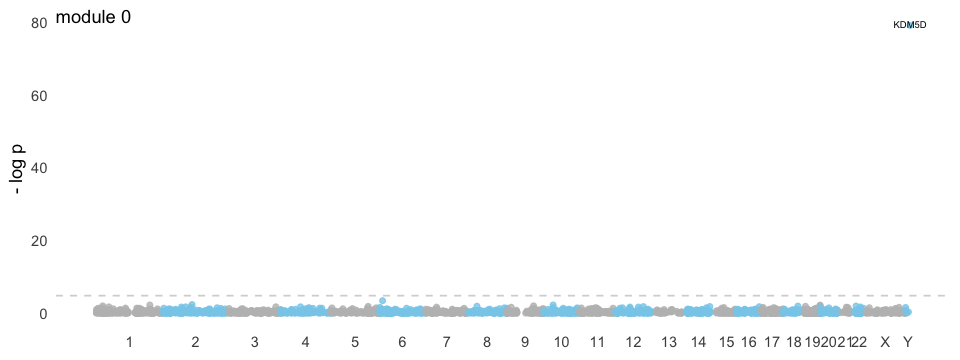

In [251]:
options(repr.plot.width=8, repr.plot.height=3)
plotModuleHits(data.plot, main='module 0')$p

## Now run all modules

In [257]:
p.list = list()
hits.df = data.frame()
number_modules = length(unique(PCs$i))
for (j in seq(number_modules) - 1) { # index start at 0
    responses = PCs %>% filter(i == j) %>% arrange(patient) %>% .$PC1
    set.seed(1)
    model.fit = vbsr(y=responses, X=t(GEP.transformed), family='normal', n_orderings = 50)
    data.plot = data.frame(hgnc_symbol=rownames(GEP.transformed), minuslogp=-log10(model.fit$pval)) %>%
       left_join(locations) %>%
       mutate(chromosome_name = factor(chromosome_name, levels=c(1:22, 'X', 'Y')))
    if (sum(data.plot$minuslogp > -log10(0.05/m)) == 0) next
    else {
       res  = plotModuleHits(data.plot, main=paste0('module ', j))
       p.list[[j+1]] = res$p
       hits = res$hits
       hits$i = j
       hits.df = rbind(hits.df, hits)
    }
}

Joining, by = "hgnc_symbol"
Warning message:
“Column `hgnc_symbol` joining factor and character vector, coercing into character vector”Joining, by = "chromosome_name"
Joining, by = "hgnc_symbol"
Warning message:
“Column `hgnc_symbol` joining factor and character vector, coercing into character vector”Joining, by = "chromosome_name"
Joining, by = "hgnc_symbol"
Warning message:
“Column `hgnc_symbol` joining factor and character vector, coercing into character vector”Joining, by = "hgnc_symbol"
Warning message:
“Column `hgnc_symbol` joining factor and character vector, coercing into character vector”Joining, by = "chromosome_name"
Joining, by = "hgnc_symbol"
Warning message:
“Column `hgnc_symbol` joining factor and character vector, coercing into character vector”Joining, by = "chromosome_name"
Joining, by = "hgnc_symbol"
Warning message:
“Column `hgnc_symbol` joining factor and character vector, coercing into character vector”Joining, by = "hgnc_symbol"
Warning message:
“Column `hgnc_sym

In [234]:
l = p.list
names(l) <- seq_along(l)
l = plyr::compact(l)

In [245]:
options(repr.plot.width=15, repr.plot.height=12)
p.all = plot_grid(plotlist=l, ncol=2)

Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

In [247]:
ggsave(p.all, file='../../figures/Figueroa/vbsr.png', width=18, height=12, unit='in')

In [262]:
## Get the hits for each modules and save it as an object to be analyzed later
write.table(hits.df, file='../../data/Figueroa/vBsr/hits.csv', sep=',', row.names=F)

# Methylation cluster gene set enrichment analysis using PANTHER

In [20]:
cluster.membership <- HM27[, n]
gene.cluster <- list()
for (i in seq(length(unique(cluster.membership)))) {
    cluster.idx <- which(cluster.membership == i)
    print(paste0('Cluster ', i, ' has ', length(cluster.idx), ' probes.'))
    gene.cluster[[i]] <- rownames(HM27)[cluster.idx]
}

[1] "Cluster 1 has 326 probes."
[1] "Cluster 2 has 290 probes."
[1] "Cluster 3 has 671 probes."
[1] "Cluster 4 has 525 probes."
[1] "Cluster 5 has 816 probes."
[1] "Cluster 6 has 656 probes."
[1] "Cluster 7 has 461 probes."


In [21]:
extractUniqueGenes <- function(genes) { 
    unique(unlist(sapply(genes, function(x) strsplit(x, split=';')[[1]])))
}

for (i in seq(unique(cluster.membership))) {
    write.table(extractUniqueGenes(gene.cluster[[i]]), file=paste0('../data/Figueroa/HELP/cluster', i, '.tsv'), row.names=F, col.names=F, quote=F)
}

gene set enrichment analysis is obtained using PANTHER classification system on [GOC](http://geneontology.org)

In [ ]:
cluster1 <- read.csv('../data/Figueroa/HELP/cluster1.txt', skip=5, header=T, sep='\t', stringsAsFactor=F)

no significant result for cluster 2

In [35]:
cluster3 <- read.csv('../data/Figueroa/HELP/cluster3.txt', skip=5, header=T, sep='\t', stringsAsFactor=F)

no significant result for cluster 4

In [42]:
cluster5 <- read.csv('../data/Figueroa/HELP/cluster5.txt', skip=5, header=T, sep='\t', stringsAsFactor=F)
cluster6 <- read.csv('../data/Figueroa/HELP/cluster6.txt', skip=5, header=T, sep='\t', stringsAsFactor=F)
cluster7 <- read.csv('../data/Figueroa/HELP/cluster7.txt', skip=5, header=T, sep='\t', stringsAsFactor=F)

Table of concensus clusters

In [47]:
library(xtable)
num.genes <- lapply(gene.cluster, length)

In [ ]:
# genes with similar methylation patterns (why cluster by similar methylation patterns, may be involved in the same biological process)
# those genes with similar gene expression patterns might be regulating the methylation level (if gene expression is high, methylation level is also high)
# would expect genes with similar patterns are involved in some general biological process instead of very specific ones. Rank by intersection will be good.

In [152]:
num.genes[[1]]
colnames(cluster1) <- c('BP', 'ref size', 'intersection', 'expected', '+/-', 'fold enrichment', 'raw P', 'FDR')
table1 <- cluster1 %>%
    arrange(desc(intersection)) %>%
    dplyr::filter(intersection > num.genes[[1]]/4 & FDR < 0.003)
table1
print(xtable(table1[,-5], display=c("s", "s","d","d","f","f","g","g")), include.rownames=FALSE)

[1] 326

BP,ref size,intersection,expected,+/-,fold enrichment,raw P,FDR
cell communication (GO:0007154),5693,97,63.04,+,1.54,1.81e-06,0.00236
signaling (GO:0023052),5578,96,61.77,+,1.55,1.49e-06,0.00233


% latex table generated in R 3.4.0 by xtable 1.8-2 package
% Tue Jun 12 11:35:41 2018
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrr}
  \hline
BP & ref size & intersection & expected & fold enrichment & raw P & FDR \\ 
  \hline
cell communication (GO:0007154) & 5693 &  97 & 63.04 & 1.54 & 1.8e-06 & 0.0024 \\ 
  signaling (GO:0023052) & 5578 &  96 & 61.77 & 1.55 & 1.5e-06 & 0.0023 \\ 
   \hline
\end{tabular}
\end{table}


In [153]:
num.genes[[5]]
colnames(cluster5) <- c('BP', 'REF size', 'intersection', 'expected', '+/-', 'fold enrichment', 'raw P', 'FDR')
table5 <- cluster5 %>%
    arrange(desc(intersection)) %>%
    dplyr::filter(intersection > num.genes[[5]]/4 & FDR < 1e-10)
table5
print(xtable(table5[,-5], display=c("s", "s","d", "d","f","f","g","g")), include.rownames=FALSE)

[1] 816

BP,REF size,intersection,expected,+/-,fold enrichment,raw P,FDR
developmental process (GO:0032502),5654,310,199.38,+,1.55,9.24e-18,1.45e-13
anatomical structure development (GO:0048856),5299,293,186.86,+,1.57,5.64e-17,4.41e-13
multicellular organism development (GO:0007275),4918,275,173.42,+,1.59,2.73e-16,1.07e-12
system development (GO:0048731),4309,244,151.95,+,1.61,1.01e-14,2.62e-11


% latex table generated in R 3.4.0 by xtable 1.8-2 package
% Tue Jun 12 11:35:50 2018
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrr}
  \hline
BP & REF size & intersection & expected & fold enrichment & raw P & FDR \\ 
  \hline
developmental process (GO:0032502) & 5654 & 310 & 199.38 & 1.55 & 9.2e-18 & 1.4e-13 \\ 
  anatomical structure development (GO:0048856) & 5299 & 293 & 186.86 & 1.57 & 5.6e-17 & 4.4e-13 \\ 
  multicellular organism development (GO:0007275) & 4918 & 275 & 173.42 & 1.59 & 2.7e-16 & 1.1e-12 \\ 
  system development (GO:0048731) & 4309 & 244 & 151.95 & 1.61 & 1e-14 & 2.6e-11 \\ 
   \hline
\end{tabular}
\end{table}


In [154]:
num.genes[[6]]
colnames(cluster6) <- c('BP', 'REF size', 'intersection', 'expected', '+/-', 'fold enrichment', 'raw P', 'FDR')
table6 <- cluster6 %>%
    arrange(desc(intersection)) %>%
    dplyr::filter(intersection > num.genes[[6]]/4 & FDR < 0.03)
table6
print(xtable(table6[,-5], display=c("s", "s","d", "d","f","f","g","g")), include.rownames=FALSE)

[1] 656

BP,REF size,intersection,expected,+/-,fold enrichment,raw P,FDR
developmental process (GO:0032502),5654,199,147.52,+,1.35,2.20e-06,0.00573
cellular component organization or biogenesis (GO:0071840),5773,196,150.62,+,1.30,3.08e-05,0.02680
cellular component organization (GO:0016043),5584,192,145.69,+,1.32,2.03e-05,0.02110
anatomical structure development (GO:0048856),5299,190,138.25,+,1.37,1.33e-06,0.00520
multicellular organism development (GO:0007275),4918,184,128.31,+,1.43,1.05e-07,0.00165


% latex table generated in R 3.4.0 by xtable 1.8-2 package
% Tue Jun 12 11:36:41 2018
\begin{table}[ht]
\centering
\begin{tabular}{lrrrlrr}
  \hline
BP & REF size & intersection & expected & fold enrichment & raw P & FDR \\ 
  \hline
developmental process (GO:0032502) & 5654 & 199 & 147.52 & 1.35 & 2.2e-06 & 0.0057 \\ 
  cellular component organization or biogenesis (GO:0071840) & 5773 & 196 & 150.62 & 1.30 & 3.1e-05 & 0.027 \\ 
  cellular component organization (GO:0016043) & 5584 & 192 & 145.69 & 1.32 & 2e-05 & 0.021 \\ 
  anatomical structure development (GO:0048856) & 5299 & 190 & 138.25 & 1.37 & 1.3e-06 & 0.0052 \\ 
  multicellular organism development (GO:0007275) & 4918 & 184 & 128.31 & 1.43 & 1.1e-07 & 0.0016 \\ 
   \hline
\end{tabular}
\end{table}


In [158]:
num.genes[[7]]
colnames(cluster7) <- c('BP', 'REF size', 'intersection', 'expected', '+/-', 'fold enrichment', 'raw P', 'FDR')
table7 <- cluster7 %>%
    arrange(desc(intersection)) %>%
    dplyr::filter(intersection > num.genes[[7]]/4 & FDR < 0.015)
print(xtable(table7[,-5], display=c("s", "s","d", "d","f","f","g","g")), include.rownames=F)

[1] 461

% latex table generated in R 3.4.0 by xtable 1.8-2 package
% Tue Jun 12 11:40:11 2018
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrr}
  \hline
BP & REF size & intersection & expected & fold enrichment & raw P & FDR \\ 
  \hline
negative regulation of biological process (GO:0048519) & 5129 & 132 & 89.21 & 1.48 & 8.2e-07 & 0.013 \\ 
   \hline
\end{tabular}
\end{table}


In [159]:
num.genes[[3]]
colnames(cluster3) <- c('BP', 'REF size', 'intersection', 'expected', '+/-', 'fold enrichment', 'raw P', 'FDR')
table3 <- cluster3 %>%
    arrange(desc(intersection)) %>%
    dplyr::filter(intersection > num.genes[[3]]/4 & FDR < 0.015)
print(xtable(table3[,-5], display=c("s", "s","d", "d","f","f","g","g")), include.rownames=F)

[1] 671

% latex table generated in R 3.4.0 by xtable 1.8-2 package
% Tue Jun 12 11:41:33 2018
\begin{table}[ht]
\centering
\begin{tabular}{lrrrrrr}
  \hline
BP & REF size & intersection & expected & fold enrichment & raw P & FDR \\ 
  \hline
biological\_process (GO:0008150) & 17854 & 480 & 437.82 & 1.10 & 2.9e-08 & 0.00023 \\ 
  cellular process (GO:0009987) & 15478 & 436 & 379.56 & 1.15 & 6.1e-09 & 9.5e-05 \\ 
   \hline
\end{tabular}
\end{table}


In [233]:
library(stringr)
for (i in c(1, 3, 5,6,7)) {
    print(i)
    res <- read.csv(paste0('../data/Figueroa//vBsr/clusterAnnotated', i, '.tsv'), sep='\t', header=T, stringsAsFactor=F)
    res$description <- sapply(res$description, function(x) str_match(x, '(.*) \\[.*')[[2]])
    print(xtable(res, display=c('s', 's', 's', 'g')), include.rownames=F)
}



[1] 1
% latex table generated in R 3.4.0 by xtable 1.8-2 package
% Tue Jun 12 15:16:55 2018
\begin{table}[ht]
\centering
\begin{tabular}{llr}
  \hline
gene & description & coef \\ 
  \hline
ERBB2 & erb-b2 receptor tyrosine kinase 2 & 0.002 \\ 
  ZBTB38 & zinc finger and BTB domain containing 38 & -0.00068 \\ 
  HDAC2 & histone deacetylase 2 & 0.00059 \\ 
  RBPJ & recombination signal binding protein for immunoglobulin kappa J region & -0.00019 \\ 
  POU6F1 & POU class 6 homeobox 1 & 0.0023 \\ 
  TAL1 & TAL bHLH transcription factor 1, erythroid differentiation factor & 0.0002 \\ 
  CDCA7 & cell division cycle associated 7 & -0.00015 \\ 
  AURKB & aurora kinase B & 0.0004 \\ 
   \hline
\end{tabular}
\end{table}
[1] 3
% latex table generated in R 3.4.0 by xtable 1.8-2 package
% Tue Jun 12 15:16:55 2018
\begin{table}[ht]
\centering
\begin{tabular}{llr}
  \hline
gene & description & coef \\ 
  \hline
MED13L & mediator complex subunit 13 like & -0.00015 \\ 
  INTS6 & integrator complex subu